# Описание

## Цель

Улучшение качества рекомендаций музыкального сервиса путем точного определения и
классификации каверов.

## Задачи

Необходимо разработать решение, которое:
* классифицирует треки по признаку кавер - не кавер
* группирует каверы и исходный трек
* находит исходный трек в цепочке каверов.

## Описание данных
* Разметка каверов: Уникальные ID треков, метки (оригинал или кавер), ID исходного трека.
* Метаинформация: Дата добавления, название трека, язык, жанры, длительность и многое другое.
* Тексты песен: Уникальные ID треков, тексты треков.


# Импорт инструментария

In [91]:
import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt 
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from catboost import CatBoostClassifier

from tqdm import tqdm #импорт инструмента процесса выполнения циклов

import warnings
warnings.filterwarnings('ignore')

import torch
import transformers
from transformers import AutoTokenizer, AutoModel

#обозначение числа для random_state
RS = 12345

In [92]:
#максимальное количество символов в ячейке
pd.set_option('display.max_colwidth',200)

# Импорт данных

In [93]:
#импорт данных из файла json
covers = pd.read_json('/kaggle/input/yandex-music/covers.json', lines=True)
lyrics = pd.read_json('/kaggle/input/yandex-music/lyrics.json', lines=True)
meta = pd.read_json('/kaggle/input/yandex-music/meta.json', lines=True)

# Ознакомление с данными

## Датасет covers

Посмотрим на основную информацию о датасете, посмотрим на пропуски и дубликаты.

In [94]:
#вывод информации о датасете методом info()
covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [95]:
#вывод первых строк датасета
covers.head(15)

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER
5,None,4da9d7b6d119db4d2d564a2197798380,COVER
6,None,2bf283c05b601f21364d052ca0ec798d,COVER
7,None,5eb13cb69b6e20dd7a42030f5936a9dc,COVER
8,None,109f91266ef89cc3690079b28abfe9a3,COVER
9,76c538125fc5c9ec6ad1d05650a57de5,76c538125fc5c9ec6ad1d05650a57de5,ORIGINAL


In [96]:
#проверка полных дубликатов 
print('Число полных дубликатов:', covers.duplicated().sum())

#проверка дубликатов по столбцам
print('Число дубликатов в столбце track_id:', covers.duplicated('track_id').sum())

Число полных дубликатов: 0
Число дубликатов в столбце track_id: 0


## Выводы по датасету covers

Датасет содержит 3 столбца:
* original_track_id - уникальный идентификатор исходного трека;
* track_id - уникальный идентификатор трека;
* track_remake_type - метка, присвоенная редакторами.

Датасет содержит 71597 строк. Пропуски присутствуют в столбце *original_track_id*, что вполне логично: если песня не оригинал сама по себе, а для кавера не распознана оригинальная песня, то данного идентификатора у песни нет.

В остальных столбцах пропусков нет.

Во всех столбцах данные имеют тип object.

Предобработки не требуется.

## Датасет lyrics

Посмотрим на основную информацию о датасете, посмотрим на пропуски и дубликаты.

In [97]:
#вывод информации о датасете методом info()
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


In [98]:
#вывод первых строк датасета
lyrics.head(10)

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\nПопытками не то любить, что нужно\nТеряю смысл, ну и пусть, невыносимой стала грусть\nИ в комнате, что с потолком мне чужда\n\nЯ б уплыла в океан, сши...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,"Tell me your fable\nA fable\nTell me your fable\nTell me your fable\nTell me your fable\nA fable\nTell me your fable\nTalk to me, tenderly\nShow reality, fantasy\nWe'll bound together\nAll win in ...",0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts\nAnd how I hurt you\nCan you make it back from the aftermath?\nAnd how I left you\nNobody wants to be alone\nWith the fear of letting go\nIf you coul...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts\nAnd how I hurt you\nCan you make it back from the aftermath?\nAnd how I left you\nNobody wants to be alone\nWith the fear of letting go\nIf you coul...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm afraid your best wasn't good enough\nAnd know he never wanted you at least not the way\nYou wanted yourself to be loved\nAnd you feel like you were a m...",8d70930d09cd239c948408d1317d8659
5,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm afraid your best wasn't good enough\nAnd know he never wanted you at least not the way\nYou wanted yourself to be loved\nAnd you feel like you were a m...",b12ecdeac6ac42e1ecac96f9f15b1159
6,aaf5c8771a94127de56c08623393434a,You lost her\nAnd now you're wishing you could take back\nWhat you did wrong\nYou lost him\nHow could he breathe with the pressure that you put on?\nHow come being proud always feels so wrong\nWhe...,8ef2d56d4dea12988133f6d933401733
7,aaf5c8771a94127de56c08623393434a,You lost her\nAnd now you're wishing you could take back\nWhat you did wrong\nYou lost him\nHow could he breathe with the pressure that you put on?\nHow come being proud always feels so wrong\nWhe...,4f41809cdbbb3d3dc99491d1273e7519
8,28d69bf999a2d26c5a6365b71d07a706,If you go now\nPlease leave the light on\nJust say goodbye now and leave\n\nWith you gone now\nYou've turned the right to wrong\nIt's getting hard now to breath\n\nIt goes on and on\nBut not in my...,c8658fc634c181f05c882e1919e157df
9,b6b9656527783d76fcfa0fad73625f36,Justo ayer me di cuenta\nQue solo es cuestión de plata\nMientras diez ventanillas cobran\nUna sola es la que paga\n\nDe como piensa la gente\nA veces la diferencia\nEs tan grande que parecen\nSere...,682f310c802690104b3a633b6557bac2


In [99]:
#проверка полных дубликатов 
print('Число полных дубликатов:', lyrics.duplicated().sum())

#проверка дубликатов по столбцам
print('Число дубликатов в столбце lyricId:', lyrics.duplicated('lyricId').sum())
print('Число дубликатов в столбце text:', lyrics.duplicated('text').sum())
print('Число дубликатов в столбце track_id:', lyrics.duplicated('track_id').sum())

Число полных дубликатов: 0
Число дубликатов в столбце lyricId: 499
Число дубликатов в столбце text: 770
Число дубликатов в столбце track_id: 1137


## Выводы по датасету lyrics

Датасет содержит 3 столбца:
* lyricId - уникальный идентификатор исходного трека;
* text - текст трека;
* track_id - уникальный идентификатор трека.

Датасет содержит 11414 строк. 

Пропуски отсутствуют.

Во всех столбцах данные имеют тип object.

Полных дубликатов нет, присутствуют дубликаты во всех столбцах по отдельности. В целом логично наличие дубликатов текстов: тексты разных песен (как раз каверов) могут быть одинаковы. Также есть дубликаты по столбцу lyricId - аналогично.

Дубликаты по столбцу track_id можно трактовать следующим образом: одна и та же песня получила текст возможно из различных источников. 

Предобработка: есть смысл удалить строки со значениями-дубликатами по track_id, так как для одного и того же трека может быть только один текст. Более того, в дальнейшем, видимо, придётся объединять эту таблицу с остальными как раз по track_id.

## Датасет meta

Посмотрим на основную информацию о датасете, посмотрим на пропуски и дубликаты.

In [100]:
#вывод информации о датасете методом info()
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


In [101]:
#вывод информации о пропусках
meta.isna().sum()

track_id        1
dttm            1
title           1
language    49800
isrc          314
genres          1
duration        1
dtype: int64

In [102]:
#вывод первых строк датасета
meta.head(5)

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0


In [103]:
#вывод числовой информации о столбце duration
meta.duration.describe()

count    7.176800e+04
mean     2.049187e+05
std      8.559854e+04
min      0.000000e+00
25%      1.613700e+05
50%      1.993950e+05
75%      2.390700e+05
max      5.487300e+06
Name: duration, dtype: float64

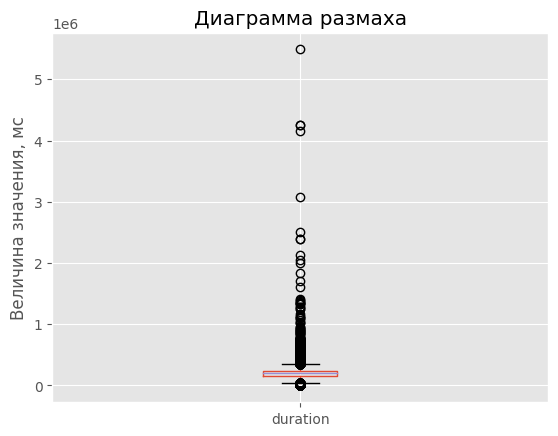

In [104]:
#вывод диаграммы размаха для столбца duration
meta.boxplot('duration')
plt.title('Диаграмма размаха')
plt.ylabel('Величина значения, мс')
plt.show()

In [105]:
meta[meta.duration == 0]

,track_id,dttm,title,language,isrc,genres,duration
266,4c7c6727575bb1572f4c326090fd365d,1.638194e+12,A Través del Vaso,None,QZNJZ2184037,"[FOLK, LATINFOLK]",0.0
267,0817441e7fb91e86edbd0e2abe429987,1.638194e+12,Entra en Mi Vida,None,QZNJZ2184038,"[FOLK, LATINFOLK]",0.0
268,900bb2cd2d4cfb52675c2dcac6a97a0e,1.638194e+12,Mi Meta Contigo,None,QZNJZ2184039,"[FOLK, LATINFOLK]",0.0
269,603cbedbd688531b9c8ab0446debcd1d,1.638194e+12,Mujeres Divinas,None,QZNJZ2184040,"[FOLK, LATINFOLK]",0.0
270,35fdcfcb577453a73494781f4f52824d,1.638194e+12,Para Qué Lastimarme,None,QZNJZ2184041,"[FOLK, LATINFOLK]",0.0
...,...,...,...,...,...,...,...
68937,e805eb7d58006a5da85b2e891a423815,1.550073e+12,Lie,None,GBMA21887386,[RAP],0.0
68938,5d405f6e0c0605ab5abedc20bfb12b20,1.550073e+12,Mind Sex,None,GBMA21887431,[RAP],0.0
70278,4776f168e2201dfd32d6e00add694c42,1.554181e+12,Societas Satanas,None,FR33T0819525,"[METAL, BLACKMETAL]",0.0
70967,1281b73dcf86f6fc9d2530a072ff9037,1.555988e+12,Vai Ter Que Rebolar,None,QZGLS1939861,"[FOLK, LATINFOLK]",0.0


2 столбца имеют подозрительные значения: dttm (datetime представлено числом), genres (жанры перечислены в составе списка), а также подозрительный пропуск- одна строка. Также в столбцу duration присутствуют нулевые значения, а в столбе language - пропуски. Предобработаем столбцы dttm, genres сразу для дальнейшнего анализа:

In [106]:
#удаление строки-пропуска по части выборки
meta=meta.dropna(subset=['track_id', 'title'])

In [107]:
#преобразование списков в столбце genres в строку с жанрами
meta["genres"] = meta["genres"].apply(lambda x: ' '.join(x))

Проверим преобразования:

In [108]:
#вывод информации о датасете методом info()
meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71768 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 4.4+ MB


In [109]:
#вывод информации о пропусках
meta.isna().sum()

track_id        0
dttm            0
title           0
language    49799
isrc          313
genres          0
duration        0
dtype: int64

In [110]:
#вывод первых строк датасета
meta.head(5)

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,DANCE,161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,ELECTRONICS,362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,FOLK LATINFOLK,260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,FOLK LATINFOLK,190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,FOLK LATINFOLK,203000.0


In [111]:
#проверка полных дубликатов 
print('Число полных дубликатов:', meta.duplicated().sum())

#проверка дубликатов по столбцам 
for i in meta.columns:
    print('Число дубликатов в столбце', i ,':' ,meta.duplicated(i).sum())


Число полных дубликатов: 0
Число дубликатов в столбце track_id : 0
Число дубликатов в столбце dttm : 44042
Число дубликатов в столбце title : 26306
Число дубликатов в столбце language : 71682
Число дубликатов в столбце isrc : 484
Число дубликатов в столбце genres : 71536
Число дубликатов в столбце duration : 48171


Все эти дубликаты имеют место, стоит отметить также, что дубликаты для столбца language включают в себя значения-пропуски.

## Выводы по датасету meta

Датасет содержит 7 столбцов:
* track_id - уникальный идентификатор трека;
* dttm - первая дата появления информации о треке;
* title - название трека;
* language - язык исполнения;
* isrc - международный уникальный идентификатор трека;
* genres - жанры;
* duration - длительность трека;

Датасет содержит 71768 строк. 

Пропуски присутствуют в столбцах *language* , *isrc*. По-хорошему можно попробовать заполнить пропуски столбца language по содержанию текстов (после объединения с текстами) или по названиям песен.

В остальных столбцах пропусков нет.

В основном в столбцах тип данных object, за исключением уже предобработанного dttm (datetime) и duration (float64)

В числе предобработки удалена полностью пустая строка, раскрыты списки в столбце genre: преобразованы в строку с перечислением жанров.

На будущее есть смысл заполнить пропуски по столбцу duration медианным значением столбца, и далее объединить в общий датасет.

# Предобработка данных

## Датасет lyrics

In [112]:
#удаление дубликатов по столбцу track_id
print('Число дубликатов до удаления:',lyrics['track_id'].duplicated().sum())
lyrics=lyrics.drop_duplicates(subset=['track_id'])
print('Число дубликатов после удаления:',lyrics['track_id'].duplicated().sum())

Число дубликатов до удаления: 1137
Число дубликатов после удаления: 0


## Датасет meta

In [113]:
#заполнение нулевых значений медианным для столбца duration
#проверка значений до заполнения
print('Число нулевых значений до заполнения:', len(meta[meta.duration == 0]))

#заполнение нулевых значений
meta[meta.duration == 0] = meta.duration.median()

#проверка заполнения
print('Число нулевых значений до заполнения:', len(meta[meta.duration == 0]))

Число нулевых значений до заполнения: 369
Число нулевых значений до заполнения: 0


In [114]:
#заполнение пропусков по столбцу language значением - заглушкой
meta['language'] = meta['language'].fillna('None')

# Объединение датасетов

In [115]:
#INNER - объединение всех датасетов
df_full=meta.merge(lyrics,on='track_id',how = 'inner').merge(covers,on='track_id',how = 'inner')

In [116]:
#вывод информации методом info
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10088 entries, 0 to 10087
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           10088 non-null  object 
 1   dttm               10088 non-null  float64
 2   title              10088 non-null  object 
 3   language           10088 non-null  object 
 4   isrc               10028 non-null  object 
 5   genres             10088 non-null  object 
 6   duration           10088 non-null  float64
 7   lyricId            10088 non-null  object 
 8   text               10088 non-null  object 
 9   original_track_id  3041 non-null   object 
 10  track_remake_type  10088 non-null  object 
dtypes: float64(2), object(9)
memory usage: 867.1+ KB


# Предобработка текстов

Была опробована версия на tf-idf, затем перешли на BERT, тк он показал лучшие результаты по классификации треков.

## Мультиязычный BERT

In [117]:
#инициализация класса векторайзера на основе предобученной мультиязычной модели BERT
class BERTVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, bert_model_name='bert-base-multilingual-cased', device='cpu'):
        self.bert_model_name = bert_model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.bert_model_name)
        self.model = AutoModel.from_pretrained(self.bert_model_name)

        if device == 'cuda':
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print('Device:', self.device)
        else:
            self.device = 'cpu'

        self.model.to(self.device)

    def fit(self, X):
        return self

    def transform(self, X):
        X = X.copy()

        embeddings = []

        batch_size = 100
        for i in tqdm(range(X.shape[0] // batch_size + 1)):
            X_batch = X.iloc[batch_size*i:batch_size*(i+1)]
            X_batch = X_batch.apply(lambda x: str(x) if len(str(x)) < 512 else x[:512])

            encoded_input = self.tokenizer(X_batch.values.tolist(), return_tensors='pt', padding=True)
            encoded_input.to(self.device)

            with torch.no_grad():
                batch_embeddings = self.model(**encoded_input)[0][:,0,:].to('cpu').numpy()

            embeddings.append(batch_embeddings)

        return np.concatenate(embeddings)

    def fit_transform(self, X):
        return self.transform(X)

In [118]:
#инициализация векторайзера для расчёта на видеокарте
bv = BERTVectorizer(device='cuda')

Device: cuda


In [119]:
#копирование предобработанного датасета
df_bert = df_full.copy()

In [120]:
#векторизация столбца с названиями
title_bert = bv.transform(df_bert['title'])

100%|██████████| 101/101 [00:11<00:00,  8.95it/s]


In [121]:
#векторизация столбца с текстами
text_bert = bv.transform(df_bert['text'])

100%|██████████| 101/101 [03:06<00:00,  1.85s/it]


In [122]:
#инициализация инструмента преобразования векторов из многомерных векторов в n-мерные
#подбор числа компонент осуществлён на основе работы моделей
truncater=TruncatedSVD(n_components=6)

title_trunc_bert = truncater.fit_transform(title_bert)
text_trunc_bert = truncater.fit_transform(text_bert)

# Решение задачи 1. Классификация треков по признаку кавер - не кавер.

# Машинное обучение

## Отбор признаков

In [123]:
#удаляем идентификаторы, тексты и названия (их заменим векторами)
df_ml=df_full.drop(columns=['track_id','isrc','lyricId','original_track_id','text','title'])

In [124]:
#добавляем векторизованные тексты и названия
df_ml=pd.concat([df_ml,pd.DataFrame(title_trunc_bert,columns=[
    'bert_title_0','bert_title_1',
    'bert_title_2','bert_title_3',
    'bert_title_4','bert_title_5'
])],axis=1)
df_ml=pd.concat([df_ml,pd.DataFrame(text_trunc_bert,columns=[
    'bert_text_0','bert_text_1',
    'bert_text_2','bert_text_3',
    'bert_text_4','bert_text_5'
])],axis=1)

In [125]:
#вывод первых строк датасета
df_ml.head()

,dttm,language,genres,duration,track_remake_type,bert_title_0,bert_title_1,bert_title_2,bert_title_3,bert_title_4,bert_title_5,bert_text_0,bert_text_1,bert_text_2,bert_text_3,bert_text_4,bert_text_5
0,1.639688e+12,EN,DANCE,161120.0,COVER,7.516093,2.824806,4.257892,-1.236445,1.240386,-1.618465,12.256012,-4.030915,-1.602309,-0.775637,0.562306,-1.078802
1,1.637762e+12,EN,ELECTRONICS,362260.0,COVER,10.630383,1.310735,2.074322,-0.828389,-1.584800,-0.408139,10.630727,1.624792,-0.473842,-1.185863,-0.708221,0.250533
2,1.637768e+12,None,FOLK LATINFOLK,211200.0,COVER,10.134890,-4.116380,-0.397422,-0.290050,-0.923032,0.164668,11.629697,-2.648498,-0.040850,0.065305,0.954215,0.610344
3,1.637773e+12,None,FOLK LATINFOLK,230680.0,COVER,10.019676,-4.038819,0.026993,0.591542,-0.295236,0.096415,11.614908,-1.783104,0.468752,-0.365426,2.077462,0.665429
4,1.666213e+12,HI,FOLK,153690.0,COVER,10.515982,-4.024069,0.799769,0.178782,-0.878442,1.580022,10.798323,-1.814991,-0.271654,-0.331943,-0.412565,-0.103965


## Исследование баланса классов

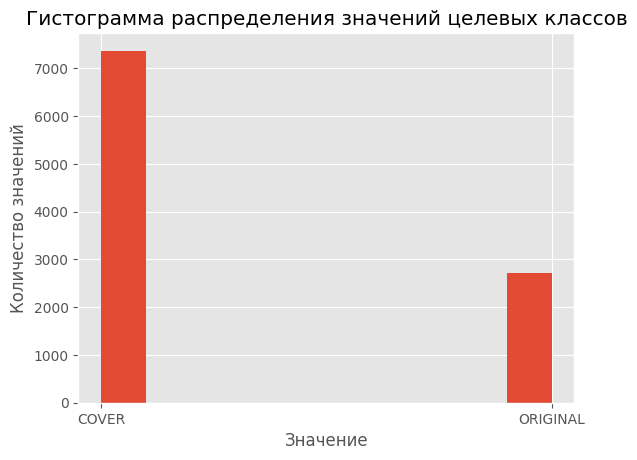

In [126]:
#построение гистограммы распределений целевых классов 
df_ml['track_remake_type'].hist()
plt.title('Гистограмма распределения значений целевых классов')
plt.xlabel('Значение')
plt.ylabel('Количество значений')
plt.show()

Присутствует дисбаланс классов, однако не слишком значительный. Попробуем обойтись стратификацией выборок train и test

## Обозначение таргета

In [127]:
#разделение features (X) и target (y)
X = df_ml.drop(columns=['track_remake_type'])
y=df_ml['track_remake_type']

## Разделение выборок

In [128]:
#разделение выборок
X_train, X_test, y_train, y_test= train_test_split(X,
                                                   y, 
                                                   test_size=.2,
                                                   random_state=RS,
                                                   stratify=y)

## Catboost

Был опробован также LightGBM, но Catboost показал лучшие результаты и был оставлен для решения. Гиперпараметры подобраны при помощи GridsearchCV (здесь не отображено)

In [129]:
%%time
cat_booster = CatBoostClassifier(logging_level='Silent',
                                     iterations=2000,
                                     random_seed=RS,
                                     custom_loss='F1',
                                     learning_rate = 0.1,
                                     feature_border_type = 'MinEntropy'                                     
                                )
cat_booster.fit(X_train, y_train, cat_features = ['language', 'genres'])
y_pred_cb=cat_booster.predict(X_test)
f1_score(y_test, y_pred_cb, pos_label = 'ORIGINAL')

CPU times: user 1min 5s, sys: 7.63 s, total: 1min 13s
Wall time: 20.4 s


0.7932067932067932

# Выводы по задаче 1

В процессе выполнения задачи классификации решены следующие задачи:
* Изучены исходные данные;
* Выполнена предобработка данных (корректировка пропусков, выбросов);
* Отобран инструмент векторизации текстовых данных: из tf-idf и BERT выбран мультиязычный BERT;
* Подготовлены данные для машинного обучения (сжатие текстовых векторов, кодирование категориальных признаков, разделение выборок, выбрана метрика f1_score);
* Отобрана модель классификатора на основе градиентного бустинга CatBoost (был опробован LGBM  и stacking-ансамбль lgbm-catboost, оба оказались хуже чем просто CatBoost);
* Подобраны гиперпараметры для финальной модели;
* Протестированна модель. Результат: f1_score для теста = 0.8

# Решение задачи 2. Кластеризация песен по группам оригинал - каверы.

## Метод кластеризации KMeans

Гипотеза 1: Применение метода KMeans для кластеризации текстов.

Для этого возьмём берт-вектора текстов, зададим начальные центроиды - это будут все песни, у которых значение поля original_track_id равняется track_id - это оригиналы, и к ним будем сводить остальные вектора методом KMeans. 

In [130]:
#сохранение индексов оригиналов
orig_ind = df_full[df_full['original_track_id'] == df_full['track_id']].index

In [131]:
# применение кластеризации для текстов
model=KMeans(n_clusters=len(orig_ind),init=text_bert[orig_ind],random_state=RS).fit(text_bert)

In [132]:
#объединение датасета название - текст - кластер для оценки
group_text_title = pd.concat([df_full['title'],df_full['text'], pd.DataFrame(model.labels_,columns = ['cluster'])],axis=1)

In [133]:
group_text_title.sort_values(by = ['cluster','title'])[100:130]

,title,text,cluster
5001,Demon's Night,Sparks - the eyes of fire\nFlying high in the night\nStorms - the arms of evil\nIt's gonna take your life\n\nYou know the bats crying\nHell bent for the death\nRain - the tears of the devil\nGonna...,39
7295,Dream On,"Every time when I look in the mirror\nAll these lines on my face getting clearer\nThe past is gone\nIt went by, like dusk to dawn\nIsn't that the way\nEverybody's got the dues in life to pay\n\nI ...",39
9420,Dream On,"Every time when I look in the mirror\nAll these lines on my face getting clearer\nThe past is gone\nIt went by, like dusk to dawn\nIsn't that the way\nEverybody's got the dues in life to pay\n\nI ...",39
2476,Falling in Love with the Enemy,They said you're not one of us\nThey said keep away\nUnder suspicion watching everything we say\n\nOver the line\nUnder the gun\nTwo hearts with nowhere to run\n\nFalling in love with the enemy\nR...,39
6065,For Those About To Rock (We Salute You),"We roll tonight\nTo the guitar bite\nYeah, yeah, oh\n\nStand up and be counted\nFor what you are about to receive\nWe are the dealers\nWe'll give you everything you need\nHail hail to the good tim...",39
10067,Forever Young,"Let's dance in style, let's dance for awhile\nHeaven can wait, we're only watchin' the skies\nHopin' for the best but expecting the worst\nAre you gonna drop the bomb or not?\n\nLet us die young o...",39
7298,Gold Feeling,"Tucked away, under a garden\nThere's Summer's goal\nI was saw shooting a gun and\nWith you, plane's gone\n\nI lost sight of your grace\nChasing my fate, chasing my fate\nAnd on a fictional moon\nI...",39
1549,Goodbye Yellow Brick Road,When are you gonna come down?\nWhen are you going to land?\nI should have stayed on the farm\nI should have listened to my old man\n\nYou know you can't hold me forever\nI didn't sign up with you\...,39
5097,Highway to Hell,"Living easy, living free\nSeason ticket on a one-way ride\nAsking nothing, leave me be\nTaking everything in my stride\nDon't need reason, don't need rhyme\nAin't nothing I would rather do\nGoing ...",39
4879,I Miss You (feat. Cobus Potgieter),Hello there\nThe angel from my nightmare\nThe shadow in the background of the morgue\nThe unsuspecting victim\nOf darkness in the valley\nWe can live like Jack and Sally\nIf we want\nWhere you can...,39


## Выводы по KMeans

На выведенных данных видно, что точность с ходу не велика: например, кластер номер 39 включает в себя множество разных песен. Но при этом, можно сказать, что реально схожие песни данным методом мы поймали: отсортировав дополнительно по названию, видим: Ride Like The Wind и This Town очевидно группы каверов. Но и множество других песен тоже лежит в этом кластере, что не очень хорошо прям скажем:)

**Важное дополнение:** по итогам консультации с Заказчиком, у него не будет размеченных данных, а значит использовать начальные центроиды не представляется возможным.

## Метод иерархического кластерного анализа

Гипотеза 2: применение метода иерархического кластерного анализа.

Для кластеризации из признаков будем использовать только преобразованные текста, без других признаков полного датасета, для минимизации шума, ухода от кодирования и стандартизации.

In [134]:
df = pd.DataFrame(text_bert)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.050751,0.199492,-0.083418,0.100602,0.219183,-0.039020,-0.069061,0.004292,-0.075403,0.189980,...,0.107384,-0.200432,-0.031831,-0.233004,0.034841,0.138959,-0.041425,0.062668,-0.009805,-0.026157
1,0.083177,0.085254,-0.026960,0.054295,0.229589,0.237325,-0.417374,-0.047525,0.118941,0.426365,...,0.269656,-0.253234,-0.392838,-0.291878,0.199602,0.172335,0.267189,0.432211,-0.074820,-0.234789
2,-0.154287,0.123245,-0.088498,0.119142,0.314289,0.194963,0.052751,-0.034279,0.083574,0.188698,...,0.192794,-0.232970,-0.014246,-0.323701,0.155302,0.190527,-0.033423,0.126830,-0.002411,0.075202
3,0.240608,0.312738,-0.179811,0.180938,0.102618,0.249019,0.077076,-0.132809,-0.038307,0.369473,...,0.149644,-0.205809,0.014069,-0.223394,0.012672,0.276715,0.123199,0.045408,0.306217,0.010850
4,0.374534,0.088674,-0.189618,-0.008706,0.361292,-0.044700,0.172161,0.248447,-0.093870,0.283015,...,0.284299,-0.146106,-0.290953,-0.153985,0.296607,0.232933,-0.026101,0.851075,-0.151175,-0.056410


Для проведения иерархического кластерного анализа
используем команду linkage из библиотеки scipy.

Три аргумента этой команды:
таблица данных,
способ вычисления расстояний между кластерами (ward, single(default), complete, average, weighted, centroid, median, weighted)
и способ вычисления расстояний между объектами (euclidean (default), cityblock, hamming, cosine).

In [135]:
#  Кластеризуем
link = linkage(df, 'ward', 'euclidean')

В объекте link хранится история объединения кластеров. Это матрица numpy (n-1) x 4, где n -- число наблюдений. Каждая строка матрицы описывает слияние очередной пары кластеров с номерами link[i, 0] и link[i, 1]. Новому кластеру присваивается номер n + i. Столбец link[i, 2] содержит расстояние между объединяемыми кластерами, а link[i, 3] -- объем нового кластера.

In [136]:
#  link точно матрица numpy?

print(type(link))
print(link.shape)

<class 'numpy.ndarray'>
(10087, 4)


In [137]:
#  Посмотрим на содержимое link
link[:15]

array([[2.905e+03, 2.967e+03, 0.000e+00, 2.000e+00],
       [6.596e+03, 6.677e+03, 0.000e+00, 2.000e+00],
       [1.796e+03, 2.076e+03, 0.000e+00, 2.000e+00],
       [5.157e+03, 5.166e+03, 0.000e+00, 2.000e+00],
       [2.657e+03, 2.658e+03, 0.000e+00, 2.000e+00],
       [4.894e+03, 9.507e+03, 0.000e+00, 2.000e+00],
       [2.634e+03, 2.965e+03, 0.000e+00, 2.000e+00],
       [5.605e+03, 6.985e+03, 0.000e+00, 2.000e+00],
       [9.146e+03, 9.286e+03, 0.000e+00, 2.000e+00],
       [3.695e+03, 9.977e+03, 0.000e+00, 2.000e+00],
       [3.952e+03, 9.651e+03, 0.000e+00, 2.000e+00],
       [3.106e+03, 8.875e+03, 0.000e+00, 2.000e+00],
       [4.883e+03, 9.202e+03, 0.000e+00, 2.000e+00],
       [4.824e+03, 9.208e+03, 0.000e+00, 2.000e+00],
       [5.464e+03, 5.569e+03, 0.000e+00, 2.000e+00]])

**Каменистая осыпь, она же локоть**

График, помогающий определить число кластеров. Особенно полезен, если данных много.
Будем использовать второй столбец матрицы ```link``` где  хранятся расстояния между объединяемыми кластерами.

In [138]:
dist = link[:, 2]
dist

array([  0.        ,   0.        ,   0.        , ..., 147.18194379,
       153.96854143, 321.3539166 ])

На графике "Каменистая осыпь" показывается зависимость расстояний между кластерами от шага объединения (обратного). На графике находим момент, начиная с которого расстояние перестанет значительно меняться.

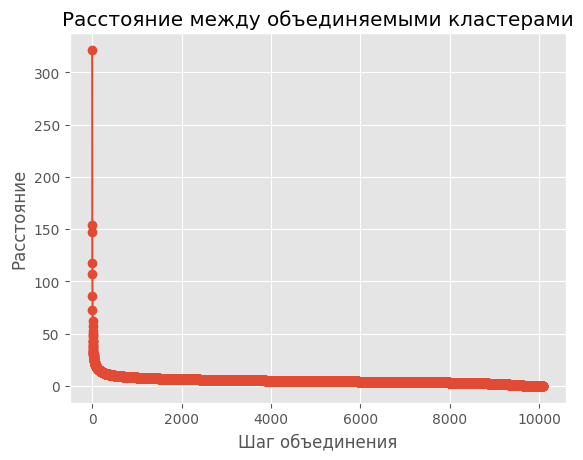

In [139]:
dist_rev = dist[::-1]
idxs = range(1, len(dist) + 1)
plt.plot(idxs, dist_rev, marker='o')
plt.title('Расстояние между объединяемыми кластерами')
plt.xlabel('Шаг объединения')
plt.ylabel('Расстояние')
plt.show()

На графике видно, что оптимально остановить объединение кластеров в промежутке от 20 до 10.

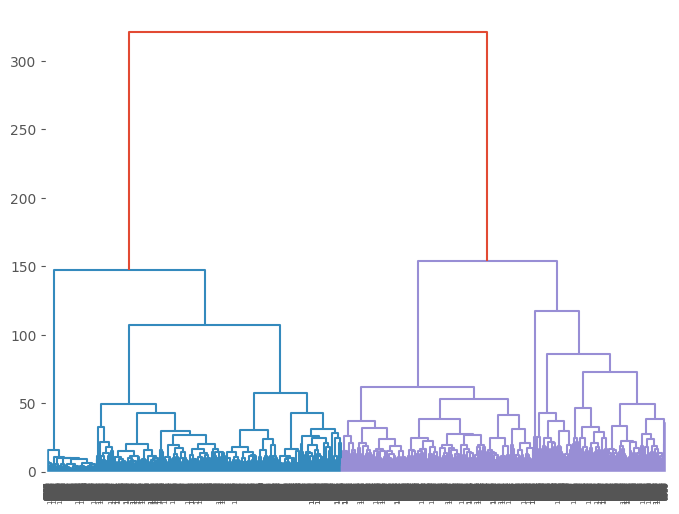

In [140]:
# # Построим дендрограмму.

fig = plt.figure(figsize=(8,6))
dn = dendrogram(link, labels= df.index.tolist())

Алгоритм подкрасил два кластера в дендрограмме. Но нам нужно гораздо больше.

Установлено, что треков у которых указан original_track_id 3041, уникальных из них 2716, и 325 каверов для которых указан original_track_id. Поэтому минимально число кластеров от которого буем отталкиваться это 325.

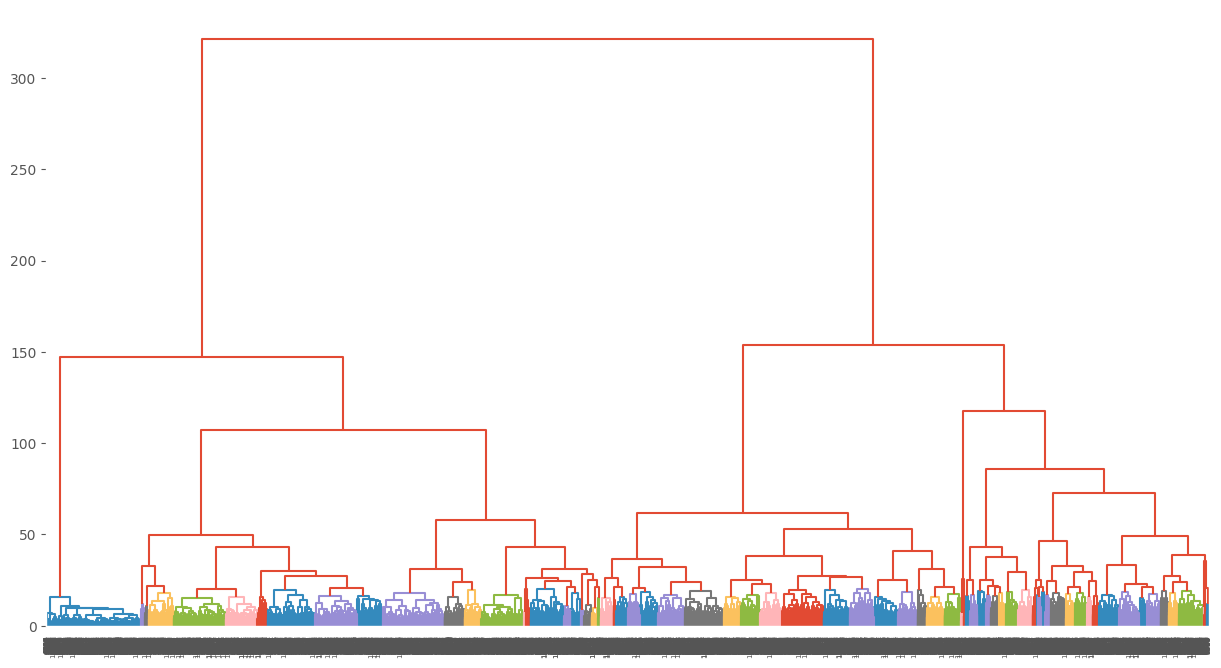

In [141]:
# Построим дендрограмму.
#  Сами задаем порог для расстояния = 20.

fig = plt.figure(figsize=(15,8))

dn = dendrogram(link, color_threshold = 20, labels=df.index.tolist())

Попробуем порог расстояния 15.

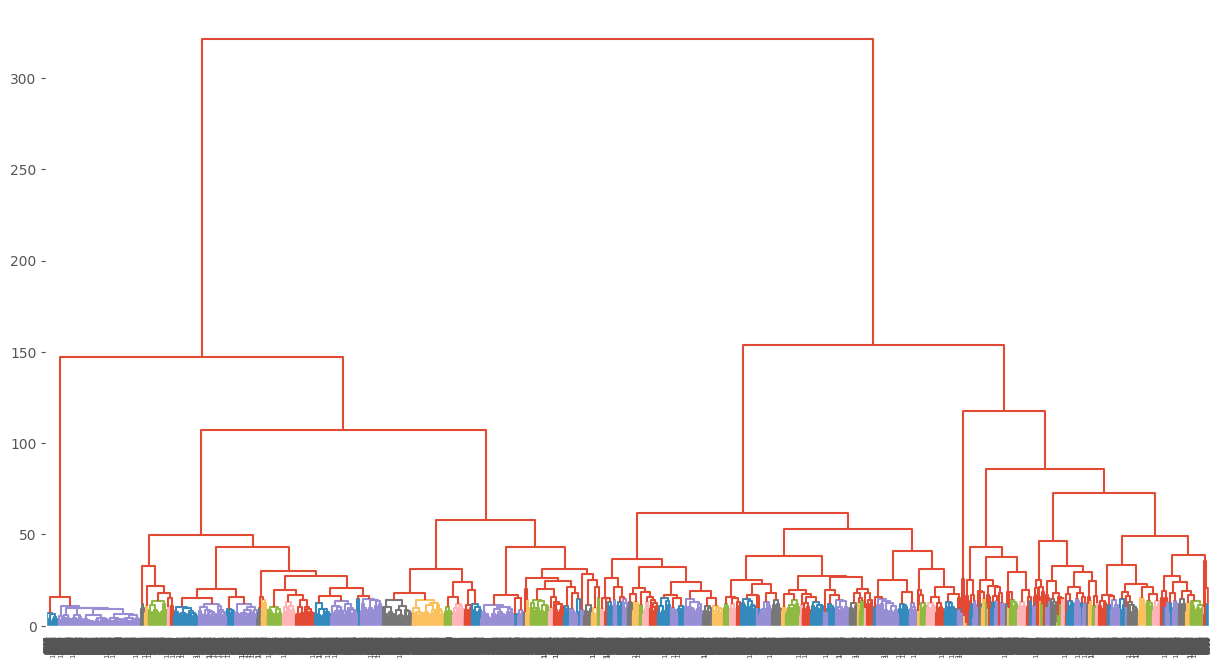

In [142]:
# Построим дендрограмму.
#  Сами задаем порог для расстояния = 15.

fig = plt.figure(figsize=(15,8))

dn = dendrogram(link, color_threshold = 15, labels=df.index.tolist())

Попробуем порог расстояния 10.

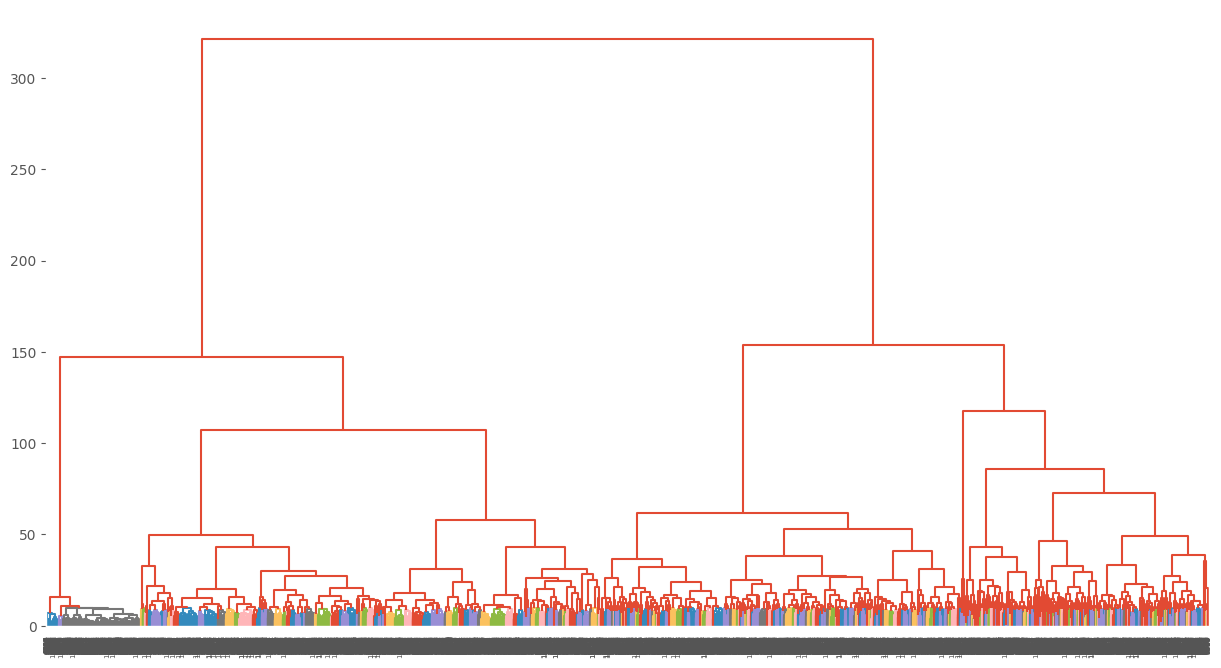

In [143]:
# Построим дендрограмму.
#  Сами задаем порог для расстояния = 10.


fig = plt.figure(figsize=(15,8))

dn = dendrogram(link, color_threshold = 10, labels=df.index.tolist())

Попробуем порог расстояния 6.

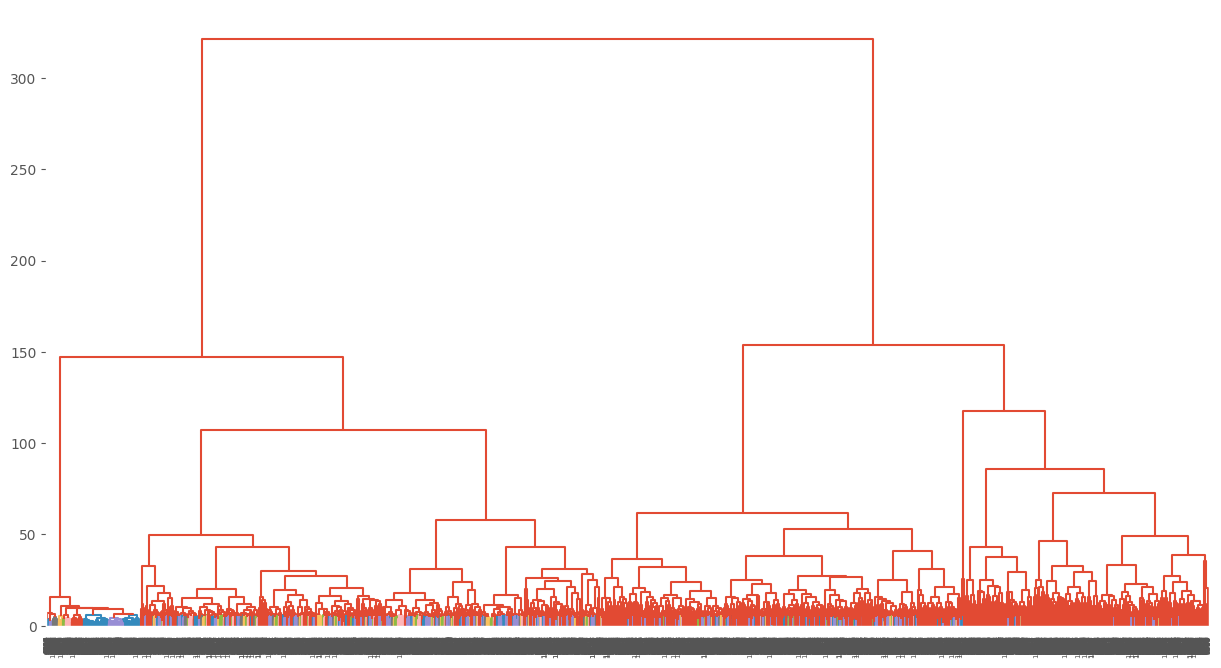

In [144]:
# Построим дендрограмму.
#  Сами задаем порог для расстояния = 6.


fig = plt.figure(figsize=(15,8))

dn = dendrogram(link, color_threshold = 6, labels=df.index.tolist())

Визуально, порог расстояния равный 10, кажется оптимальным решением, применим его.

Добавим к таблице данных df столбец cluster, содержащий код того кластера, в который попал объект. Это сделаем с помощью команды fcluster.
Первый аргумент команды это объект link, содержащий результаты кластеризации.
Вторым аргументом является пороговое значение для расстояния между кластерами.
Третий аргумент criterion указывает, как разбивать на кластеры (distance, если остановка объединений по расстоянию между кластерами.)

In [145]:
# Информация о кластерах добавляется в таблицу данных в виде столбца

# Останавливаем объединение, когда расстояние между кластерами превысит 10
df['cluster'] = fcluster(link, 10, criterion='distance')
df.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
cluster,,,,,,,,,,,,,,,,,,,,,
1,0.037619,0.160408,-0.021198,0.103149,0.147880,0.045546,-0.067593,-0.002332,-0.061339,0.277206,...,0.091483,-0.218779,0.001667,-0.211281,0.092283,0.146028,-0.011561,0.098057,0.051484,-0.089547
2,0.025706,0.147385,-0.051057,0.111748,0.169326,0.058854,-0.167564,0.039048,-0.032357,0.234225,...,0.126062,-0.166392,0.012756,-0.261897,0.023159,0.166569,0.077744,0.202958,0.013933,-0.028823
3,0.076751,0.137889,-0.023783,0.076501,0.133719,0.003596,-0.089870,0.020082,-0.058341,0.224307,...,0.090754,-0.206492,0.034799,-0.221570,0.068948,0.132455,-0.005252,0.123566,-0.008685,-0.037285
4,-0.052711,0.014913,0.114663,0.172949,0.240703,0.207653,-0.018062,0.106433,-0.113955,0.314498,...,0.081189,-0.025461,0.141258,-0.359526,0.108442,0.205515,0.178956,0.445024,-0.089022,-0.102951
5,-0.066242,0.106484,0.131862,0.083034,0.149463,0.239788,-0.087291,0.092686,-0.061976,0.594636,...,0.089730,0.040542,0.140097,-0.422173,0.048448,0.086788,0.234353,0.470010,-0.134295,-0.090085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,0.024425,0.380225,-0.173840,0.171144,0.478160,0.050775,0.084521,-0.455270,-0.608600,0.373698,...,0.437877,-0.101161,-0.901328,-0.143746,0.558499,0.341947,0.357134,0.608060,0.075021,0.196561
488,-0.035161,0.172200,0.047058,0.149820,0.149156,0.384225,-0.200259,-0.049196,0.167201,0.171847,...,0.349950,-0.005123,-0.264298,0.023401,0.038416,0.273224,0.255754,0.548245,-0.061069,0.019643
489,-0.003120,0.055495,0.167023,0.191908,0.154634,0.504930,-0.354482,-0.311568,0.166820,0.196475,...,0.511468,0.035068,-0.343704,-0.012462,-0.044984,0.321326,0.181786,0.818038,-0.111036,0.242772


С учетом того, что у не у всех каверов имеется original_track_id и у 325 имеется, количество кластеров равное 501 будем считать приемлемым.

Посчитаем сколько наблюдений попало в каждый кластер.

In [146]:
df['cluster'].value_counts().head(50)

cluster
3      677
17     165
77     131
19     124
24     118
41     113
1      109
161     94
61      94
76      84
39      82
22      82
59      81
58      80
46      78
31      72
21      70
62      70
9       70
60      70
43      69
78      64
183     60
193     60
97      59
30      58
103     58
65      57
51      57
148     56
159     54
154     53
80      53
67      53
16      52
484     51
101     51
267     51
87      49
71      49
45      48
63      45
68      45
50      44
439     44
149     44
92      43
239     42
35      41
37      40
Name: count, dtype: int64

Посмотрим на индексы произвольного кластера и посмотрим, на сколько корректно выполнена кластеризация.

**Случайный кластер №1**

(успешный)

In [147]:
df[df['cluster']==419].index.values

array([2360, 4886, 9227])

In [148]:
df_full['text'][2360]

"When you try your best and you don't succeed\nWhen you get what you want but not what you need\nWhen you feel so tired but you can't sleep\nStuck in reverse\n\nWhen the tears come streaming down your face\n'Cause you lose something you can't replace\nWhen you love someone but it goes to waste\nWhat could be worse?\n\nLights will guide you home\nAnd ignite your bones\nAnd I will try to fix you\n\nBut high up above or down below\nWhen you're too in love to let it show\nBut if you never try, you'll never know\nJust what you're worth, oh-oh\n\nLights will guide you home\nAnd ignite your bones\nAnd I will try to fix you\n\nWhen tears stream down your face\nWhen you lose something that you cannot replace\nOh, when tears stream down your face, and I\nOh-oh\nOh, when tears stream down your face\nI promise you, I'll learn from my mistakes\nWhen tears stream down your face, and I\n\nLights will guide you home\nAnd ignite your bones\nAnd I will try to fix you"

In [149]:
df_full['text'][4886]

"When you try your best but you don't succeed\nWhen you get what you want but not what you need\nWhen you feel so tired but you can't sleep\nStuck in reverse\n\nAnd the tears come streaming down your face\nWhen you lose something you can't replace\nWhen you love someone but it goes to waste\nCould it be worse?\n\nLights will guide you home\nAnd ignite your bones\nAnd I will try to fix you\n\nAnd high up above or down below\nWhen you're too in love to let it go\nBut if you never try you'll never know\nJust what you're worth\n\nLights will guide you home\nAnd ignite your bones\nAnd I will try to fix you\n\nTears stream down on your face\nWhen you lose something you cannot replace\nTears stream down on your face\nAnd I\n\nTears stream down on your face\nI promise you I will learn from my mistakes\nTears stream down on your face\nAnd I\n\nLights will guide you home\nAnd ignite your bones\nAnd I will try to fix you"

In [150]:
df_full['text'][9227]

"When you try your best but you don't succeed\nWhen you get what you want but not what you need\nWhen you feel so tired but you can't sleep\nStuck in reverse\n\nAnd the tears come streaming down your face\nWhen you lose something you can't replace\nWhen you love someone but it goes to waste\nCould it be worse?\n\nLights will guide you home\nAnd ignite your bones\nAnd I will try to fix you\n\nAnd high up above or down below\nWhen you're too in love to let it go\nBut if you never try you'll never know\nJust what you're worth\n\nLights will guide you home\nAnd ignite your bones\nAnd I will try to fix you\n\nTears stream down on your face\nWhen you lose something you cannot replace\nTears stream down on your face\nAnd I\n\nTears stream down on your face\nI promise you I will learn from my mistakes\nTears stream down on your face\nAnd I\n\nLights will guide you home\nAnd ignite your bones\nAnd I will try to fix you"

**Случайный кластер №2**

(не такой успешный)

In [151]:
df[df['cluster']==35].index.values

array([ 210,  519,  649,  709,  842,  879, 1058, 1109, 1209, 1307, 1397,
       1447, 2255, 2282, 2779, 2836, 3017, 3246, 3358, 4146, 4177, 4257,
       4327, 4437, 4653, 4686, 5058, 7100, 7671, 7870, 7928, 8143, 8156,
       8653, 8699, 8713, 9357, 9368, 9402, 9416, 9877])

In [152]:
df_full['text'][210]

'Плакала\nКогда он уходил, ты плакала\nИ на колени свои падала\nПросила всё ещё сохранить, сохранить\n\nВот она\nТеперь делами вся замотана\nЛюбит теперь только работая\nЗабыла, как опять полюбить, полюбить\n\nА ты закрыла сердце своё навсегда теперь\nИ каждый день кусала свои губы алые\nНо сколько же ты слёз, своих слёз уже пролила\nВсё было несерьезно, но жаль ты не поняла\n\nПлакала\nКогда он уходил, ты плакала\nИ на колени свои падала\nПросила всё ещё сохранить, сохранить\n\nВот она\nТеперь делами вся замотана\nЛюбит теперь только работая\nЗабыла, как опять полюбить, полюбить\n\nПлакала\nКогда он бил тебя, ты плакала\nА ты хотела его радовать\nНо он к другой опять уходил, уходил\n\nВот она\nТеперь счастлива и заботлива\nНашла того, кто не такой дурак\nИ смог тебя сильней полюбить, полюбить\n\nЛишь бы в этот раз опять не сгореть к чертям\nЛюди часто предают, только ты не предала\nПоболит и пройдёт что-то там в груди\nТы поймёшь, что пора перестать любить\n\nПлакала\nКогда он уходил,

In [153]:
df_full['text'][519]

'Бу, блять! (Просыпайтесь нахуй!)\n(Let\'s go!)\n\nГоловы сияют на моей едкой катане\nГолоса этих ублюдков по пятам бегут за нами\nПогружённый в Изанами, все колеса под глазами\nЕё взгляд убьёт любого, её взгляд убьёт цунами\n\nПохоронный марш гулей, на часах последний тик\nМоя thottie — Бравл Шелли, я несу ей дробовик\nВаши головы — мишени, я снесу их в один миг\nНикаких резких движений, ваш health bar на один hit (ha-ha-ha-ha!)\n\nДинамайк triple kill, ха, нервы на пределе\nVoice в моих ушах, я позабыл все дни недели\nКак на лезвии ножа, шквал патрон летят шрапнели\nPsychokilla — весь мой шарм, вся эта мапа — поредели\n\nЭй, погоди, мои парни на Стокгольме\nМой showdown 1х1 и мои демоны все в форме\nЕсли я зайду к вам в лобби, оно станет вам могилой\nЕсли ты зайдёшь — мне похуй, я не стартану и выйду, ага\n\n(По приказу Генерала Гавса!)\nБро, тут вообще сложная ситуация, все границы позакрывали нахуй\nВообще пиздец полный. Ща просто едем ближе ко Львову\nНо во Львове тоже пиздец нача

In [154]:
df_full['text'][649]

'Наверно, это в первый раз серьёзно\nЯ доверился тебе так просто\nВ первый раз с тобою мы так близко —\nЭто в самый первый раз\n\nНаверно, это в первый раз серьёзно\nЯ доверился тебе так просто\nВ первый раз с тобою мы так близко —\nЭто в самый первый раз\n\nТвои белые крылья\nИ глаза-незабудки\nОкна плакали пылью, размытые городом в старой маршрутке\nТы сидела напротив\nА я замер, как школьник\nДа, романтики мало, но это так просто, что даже прикольно\nЕдут мимо машины\nЛюди уткнулись в экраны мобильных\nВсё стало фоном, как будто бы в фильме\nВедь я не любил эти сопли ванильные\n\nТы будто ангел во втором ряду\nСмотришь, как тихо облака плывут\nА я давно проехал свой маршрут\n\nНаверно, это в первый раз серьёзно\nЯ доверился тебе так просто\nВ первый раз с тобою мы так близко —\nЭто в самый первый раз\n\nНаверно, это в первый раз серьёзно\nЯ доверилась тебе так просто\nВ первый раз с тобою мы так близко —\nЭто в самый первый раз\n\nНаверно, это в первый раз\nКогда мои глаза увидели т

In [155]:
df_full['text'][842]

'А я найду тебя, где бы ты бы ни была\nС кем бы ты бы ни была, где бы ни плыла\nСигаретным пеплом\nТы потушила ведь меня, м, вредина\nГде бы ты бы ни была\nС кем бы ты бы ни была, где бы ни плыла\nСигаретным пеплом\nТы потушила ведь меня, м, вредина\n\nВ голове играет блюз, наверное, это мой плюс\nУмножается пульс, когда на тебя смотрю\nПогляди на мир, непобедима ты\nДьявол темноты, я так на тебя залип\n\nИ она — мина, бахнет анонимно\nОна вертит серый дым, наливая в бокал вина\nИ она — мина, бахнет анонимно\nОна пахнет, как малина, вина\n\nА я найду тебя, где бы ты бы ни была\nС кем бы ты бы ни была, где бы ни плыла\nСигаретным пеплом\nТы потушила ведь меня, м, вредина\nГде бы ты бы ни была\nС кем бы ты бы ни была, где бы ни плыла\nСигаретным пеплом\nТы потушила ведь меня, м, вредина\n\nСен алыстаганда менден, менин жүрөгүм сокпойт (Сокпойт)\nСен кучактаганда мени, менин жүрөгүм токтойт\nЖүрөгүм отто, сен тарапка аны октойм\nМен тоголонуп тоголок топтой кеттим башкаларын тоготпой (Тог

In [156]:
df_full['text'][879]

'Сколько мы с тобой летали\nМимо крыш и домов, полетишь ли ты вновь\nСвет загорится, и я лечу на огонь будто мотылек\nНам будет снится любовь, что никто из нас не уберег\nДали волю чувствам, потратив столько лет\nМы стали фотографиями на столе\nЗа всё простить\nЯ просто отпускаю, и ты просто отпусти\nСколько мы с тобой летали\nМимо крыш и домов, полетишь ли ты вновь\nМы с тобой всю жизнь проспали\nОтпускаю без слов\nЭто всё, что я смог\nЗнали бы мы раньше, что будет так\nКапли на цветах, слезы как вода\nЯ бы всё отдал, чтобы никогда\nНе мучить себя, не мучить тебя\nДали волю чувствам, потратив столько лет\nМы стали фотографиями на столе\nЗа всё простить\nЯ просто отпускаю, и ты отпусти\nСколько мы с тобой летали\nМимо крыш и домов, полетишь ли ты вновь\nМы с тобой всю жизнь проспали\nОтпускаю без слов\nЭто всё, что я смог'

## Вывод по иерархической кластеризации
* Как можно наблюдать наша модель кластеризации не смогла эффективно объединить треки в кластеры, у нее корректно получается определить только язык, сами треке в кластере трудно назвать каверами)
* Нами также были рассмотрены модель DBSCAN, по результат схож, поэтому добавлять в конечный вариант не стали.

# Общие выводы по работе

Перед командой стояла цель нахождения решения для обнаружения треков каверов для внедрения в систему рекомендаций треков пользователю музыкального сервиса.
 В ходе декомпозиции запроса было выделено три задачи, а именно:
* Задача классификации, итогом которой должна была стать система, которая может классифицировать треки по признаку кавер-некавер;
* Задача кластеризации, призванная связывать (группировать) каверы и исходный трек;
* Задача ранжирования, решение которой находило бы исходный трек в цепочке каверов.

**Во-первых, рамках работы над классификацией**, были произведены следующие действия и получены выводы:
* Изучены исходные данные;
* Выполнена предобработка данных (корректировка пропусков, выбросов);
* Отобран инструмент векторизации текстовых данных: из tf-idf и BERT выбран мультиязычный BERT;
* Подготовлены данные для машинного обучения (сжатие текстовых векторов, разделение выборок, выбрана метрика f1_score);
* Отобрана модель классификатора на основе градиентного бустинга CatBoost (был опробован LGBM  и stacking-ансамбль lgbm-catboost, оба оказались хуже чем просто CatBoost);
* Подобраны гиперпараметры для финальной модели;
* Протестированна модель. Результат: f1_score для теста = 0.8


**Во-вторых, решая задачу кластеризации**, команда анализировала оптимальные методы работы, были рассмотрены алгоритмы K-means, KNN, DBSCAN. Было сделано предположение о том, что эффективной могла бы оказаться кластеризация с ограничением (Semi-supervised learning), поскольку по условиям задачи «не для всех каверов известны идентификаторы исходных треков», в силу недостатка времени и опыта данное решение воспроизвести не удалось. Более того, в конце возникла идея после кластеризации проверять кластеры на одинаковость названий песен, тем самым "кластеризуя кластеры".

Также обсуждались методы-обертки и возможность использования LSTM.

**В-третьих, работая над задачей ранжирования**, команда сошлась на том, что необходимо использовать попарный подход, однако столкнулась с проблемой отсутствия необходимой разметки, оценки асессоров. В силу чего решить данную задачу не получилось. 

Так как особенность задачи ранжирования заключается в том, что качество результата зависит от порядка следования документов в рамках конкретного запроса, то есть имеет значение релевантность документа/текста относительно других документов/текстов, а не абсолютное значение релевантности, нам не хватило разметки оценки релевантности. 

Как нам показалось, для нормального ранжирования нужно было хотя бы кластеризовать достаточно точно, либо нужна была бы дополнительная разметка внутри кластеров.
